# let's make neural network from scratch using numpy
### Author: Alperen Demirci
### Mail: alperendemirci65@gmail.com 
### Date: 23-03-2024

## Introduction
In this notebook, I will implement a neural network from scratch using numpy. I will use the MNIST dataset to train the neural network. I will use the leaky ReLU activation function and the cross-entropy loss function. I will also implement the forward and back propagation algorithms to train the neural network.

* [1. Importing Libraries](#1)
* [2. Load and Preprocess Data](#2)
* [3. Neural Network](#3)
    * [3.1. AlpereNet](#3.1)

* [4. Conclusion](#4)

### Importing Libraries <a id="1"></a>

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

### Load and Preprocess Data <a id="2"></a> 

In [93]:
# Set random seed
random_state = check_random_state(42)

# Load data from CSV
data = pd.read_csv('train.csv')

# Separate features and labels
X = data.drop(columns=['label'])  # Features
y = data['label']  # Labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode the labels
def one_hot_encode(labels, num_classes=10):
    num_samples = len(labels)
    one_hot_labels = np.zeros((num_classes, num_samples))
    one_hot_labels[labels, np.arange(num_samples)] = 1
    return one_hot_labels


* Checking the data shapes

In [94]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((33600, 784), (33600,), (8400, 784), (8400,))

* Tranforming the data to the desired shape

In [95]:
X_train = X_train.T
X_test = X_test.T
y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((784, 33600), (10, 33600), (784, 8400), (10, 8400))

### Defining the neural network (MLP) <a id="3"></a>
- input layer: 786x128 nodes
- hidden layer: 128x64 nodes 
- hidden layer: 64x32 nodes
- output layer: 32x10 nodes

### Activation function(s)
* sigmoid function
* ReLU function
* leaky ReLU function
* tanh function
* softmax function - for output layer since we are dealing with multi-class classification

* we have written our code to be able to use **any of these activation functions**

### Loss function
* cross-entropy loss function

### AlpereNet <a id="3.1"></a>
* We will define our neural network as a class called AlpereNet
* We will implement the forward pass and the backward pass in this class
* We will also implement the train and predict methods in this class
* We will use the MNIST dataset to train and test our neural network

In [96]:
class AlpereNet:
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x) + 1e-6)
    
    @staticmethod
    def relu(x):
        return np.maximum(0, x)
    
    @staticmethod
    def tanh(x):
        return np.tanh(x)
    
    @staticmethod
    def leaky_relu(x):
        return np.maximum(0.01*x, x)
    
    @staticmethod
    def derivative_leaky_relu(x):
        return 0.01 * (x < 0) + 1 * (x > 0)
    
    @staticmethod
    def softmax(x):
        exps = np.exp(x)
        return exps / (np.sum(exps, axis=0)+1e-6)

    @staticmethod
    def derivative_sigmoid(x):
        return x * (1 - x)
    
    @staticmethod
    def derivative_relu(x):
        return 1 * (x > 0)
    
    @staticmethod
    def derivative_tanh(x):
        return 1 - x**2

    def __init__(self):
        self.layers = []
        self.weights = []
        self.biases = []
        self.activation = []
        self.derivative = []

    def add_layer(self, units, input_shape=None,activation=sigmoid, derivative=derivative_sigmoid):
        if input_shape:
            self.weights.append(np.random.randn(units, input_shape)*0.01)
        else:
            self.weights.append(np.random.randn(units, self.weights[-1].shape[0])*0.01)
        self.biases.append(np.random.randn(units,1)*0.01)
        self.layers.append(np.zeros((units, 1)))
        self.activation.append(activation)
        self.derivative.append(derivative)

    def random_init(self):
        for i in range(len(self.weights)):
            self.weights[i] = np.random.randn(self.weights[i].shape[0], self.weights[i].shape[1])*0.01
            self.biases[i] = np.random.randn(self.biases[i].shape[0], 1)*0.01

    def forward(self, X):
        if(len(self.layers)==len(self.weights)):
            self.layers.insert(0, X)
        else:
            self.layers[0] = X
        for i in range(1,len(self.weights)):
            self.layers[i] = self.activation[i-1](np.dot(self.weights[i-1], self.layers[i-1]) + self.biases[i-1])
        self.layers[-1] = self.softmax(np.dot(self.weights[-1], self.layers[-2]) + self.biases[-1])
        return self.layers[-1]
    
    def backward(self, y):
        m = y.shape[1]
        deltas = []
        deltas.append((self.layers[-1] - y)*1/m)
        for i in range(len(self.layers)-2, 0, -1):
            deltas.insert(0, np.dot(self.weights[i].T, deltas[0]) * self.derivative[i-1](self.layers[i]))
        return deltas
    
    def update(self, deltas, lr):
        changes = []
        for i in range(len(self.weights)):
            changes.append(np.sum(np.dot(deltas[i], self.layers[i].T)))      
            self.weights[i] -= lr * np.dot(deltas[i], self.layers[i].T)
            self.biases[i] -= lr * np.sum(deltas[i], axis=1, keepdims=True)
        return self.weights, self.biases, changes

    def calculate_loss(self,Y, Y_hat):
        m = Y.shape[1]
        L_sum = np.sum(np.multiply(Y, np.log(Y_hat+1e-6)))
        L = -(1/m) * L_sum
        return L
        
    def fit(self, X, y, epochs=100, lr=0.01):
        self.random_init()
        loss = []
        for epoch in range(epochs):
            self.forward(X)
            deltas = self.backward(y)
            for i in range(len(self.weights)):
                self.weights[i] -= lr * np.dot(deltas[i], self.layers[i].T)
                self.biases[i] -= lr * np.sum(deltas[i], axis=1, keepdims=True)
         
            if epoch % 10 == 0:
                print(f'Epoch {epoch} Loss: {self.calculate_loss(y, self.layers[-1])}')
                loss.append(self.calculate_loss(y, self.layers[-1]))
        return loss
    
    def predict(self, X):
        return self.forward(X).argmax(axis=0)

### so how can we train our neural network?
* It's really simple actually. We will use the backpropagation algorithm to train our neural network. The backpropagation algorithm is an algorithm that calculates the gradient of the loss function with respect to the weights of the network. We will use this gradient to update the weights of the network using the gradient descent algorithm.

* First you have to create an instance of a AlpereNet class. Then you can train the network using the **fit** method. You can also use the predict method to make predictions using the trained network.


In [97]:
AlpNet = AlpereNet()
AlpNet.add_layer(128, 784, activation=AlpereNet.leaky_relu, derivative=AlpereNet.derivative_leaky_relu)
AlpNet.add_layer(64, activation=AlpNet.leaky_relu, derivative=AlpNet.derivative_leaky_relu)
AlpNet.add_layer(32, activation=AlpNet.leaky_relu, derivative=AlpNet.derivative_leaky_relu)
AlpNet.add_layer(10, activation=AlpereNet.softmax, derivative=AlpereNet.softmax)

* just checking if our forward and backward propagation functions are working correctly

In [98]:
pred = AlpNet.forward(X_train)
pred = pd.DataFrame(pred)
pred = pred.T
pred.head()

,0,1,2,3,4,5,6,7,8,9
0,0.103156,0.099368,0.099411,0.099888,0.100960,0.099173,0.099782,0.100792,0.098891,0.098579
1,0.103160,0.099369,0.099402,0.099888,0.100958,0.099179,0.099784,0.100792,0.098888,0.098580
2,0.103155,0.099367,0.099417,0.099891,0.100960,0.099170,0.099779,0.100791,0.098891,0.098579
3,0.103149,0.099385,0.099409,0.099883,0.100953,0.099165,0.099788,0.100778,0.098893,0.098597
4,0.103154,0.099365,0.099408,0.099887,0.100962,0.099176,0.099784,0.100788,0.098896,0.098581


In [100]:
losses2= AlpNet.fit(X_train, y_train, epochs=1000, lr=0.5)

Epoch 0 Loss: 2.302544612195333
Epoch 10 Loss: 2.301639263678173
Epoch 20 Loss: 2.3013176845682417
Epoch 30 Loss: 2.3012024091138352
Epoch 40 Loss: 2.3011597438540448
Epoch 50 Loss: 2.3011426115300333
Epoch 60 Loss: 2.301134408751874
Epoch 70 Loss: 2.301129238651431
Epoch 80 Loss: 2.3011249700832286
Epoch 90 Loss: 2.3011208068292284
Epoch 100 Loss: 2.301116414243861
Epoch 110 Loss: 2.3011116127332985
Epoch 120 Loss: 2.301106273018221
Epoch 130 Loss: 2.3011002604988584
Epoch 140 Loss: 2.301093421988123
Epoch 150 Loss: 2.3010855652781057
Epoch 160 Loss: 2.3010764502440257
Epoch 170 Loss: 2.3010657590894694
Epoch 180 Loss: 2.3010530725355824
Epoch 190 Loss: 2.301037829126215
Epoch 200 Loss: 2.3010192378724543
Epoch 210 Loss: 2.300996143590405
Epoch 220 Loss: 2.3009668558374403
Epoch 230 Loss: 2.300928772871939
Epoch 240 Loss: 2.300877741702758
Epoch 250 Loss: 2.300807065689847
Epoch 260 Loss: 2.300705136198178
Epoch 270 Loss: 2.300549642320998
Epoch 280 Loss: 2.3002950899080803
Epoch 290 

* let's check our accuracy on both training and test data

In [102]:
print(f'Test Accuracy: {np.mean(AlpNet.predict(X_test) == y_test.argmax(axis=0))}')
print(f'Train Accuracy: {np.mean(AlpNet.predict(X_train) == y_train.argmax(axis=0))}')
print(f'Final Loss: {losses2[-1]}')
print("Shapes of the data:")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Test Accuracy: 0.9575
Train Accuracy: 0.9980654761904761
Final Loss: 0.01688534611871003
Shapes of the data:
(784, 33600) (10, 33600) (784, 8400) (10, 8400)


* let's plot the loss and accuracy for each epoch on training data

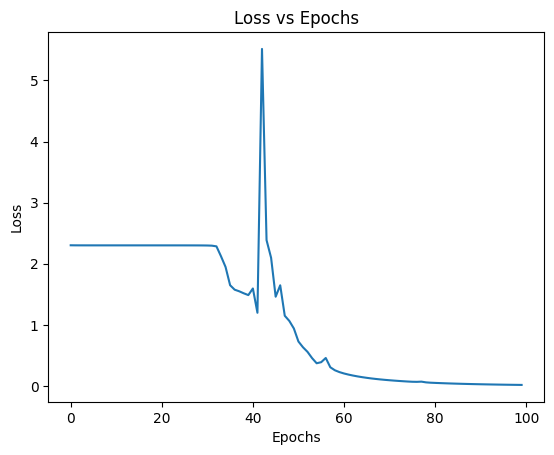

In [103]:
plt.plot(losses2)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [104]:
predictions = AlpNet.predict(X_test)
y_test_a = y_test.argmax(axis=0)
print(f'Accuracy: {np.mean(predictions == y_test_a)}')

Accuracy: 0.9575


* let's check our predicted and ground truth labels to see how does our model behave on test data

In [105]:
preds = AlpNet.predict(X_train)
y_train_a = y_train.argmax(axis=0)
preds = pd.Series(preds)
y_train_a = pd.Series(y_train_a)
print("Predicted labels: ",preds.value_counts())
print("Real labels: ",y_train_a.value_counts())

Predicted labels:  1    3752
7    3519
3    3480
2    3348
9    3344
6    3312
0    3307
4    3259
8    3249
5    3030
Name: count, dtype: int64
Real labels:  1    3747
7    3521
3    3481
9    3350
2    3342
6    3310
0    3305
4    3258
8    3250
5    3036
Name: count, dtype: int64


* let's save the model parameters to use it later

In [108]:
import copy
weights_trained = copy.deepcopy(AlpNet.weights)
biases_trained = copy.deepcopy(AlpNet.biases)

* here we have a two functions which we can see some samples from the test data and their predicted labels

In [109]:
def plot_image(image):
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.show()

def plot_image_predictions(images, predictions):
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Predicted: {predictions[i]}')
    plt.show()

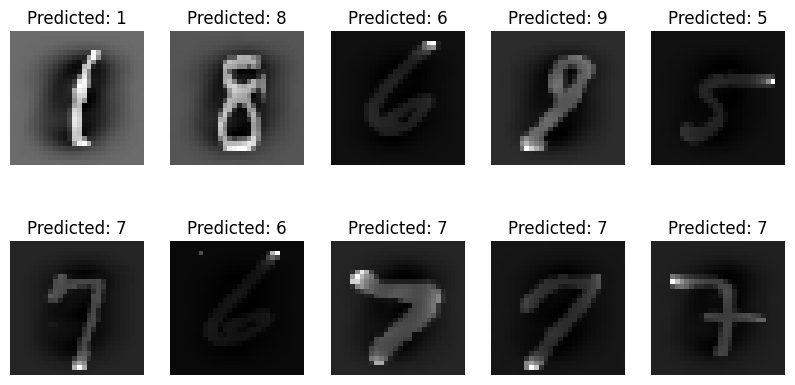

In [110]:
plot_image_predictions(X_test.T, predictions)

### Conclusion <a id="4"></a>
* In this notebook, I implemented a neural network from scratch using numpy. I used the MNIST dataset to train the neural network. I used the ReLU activation function and the cross-entropy loss function. I also implemented the backpropagation algorithm to train the neural network. I achieved an accuracy of **95.75%** on the test data.
* It took around **4 minutes** to train the neural network on the MNIST dataset using a CPU. Learning rate is 0.5 and the number of epochs is 1000. CPU is MacBook Pro M3 Pro 11 cores.

* I hope you enjoyed this notebook and found it helpful. If you have any questions or suggestions, feel free to leave a comment below.

* Thank you for reading!
